# Python Tutorial III: Modules and Classes

In today's tutorial we'll learn how to build our own python modules and classes.  We'll start with modules:

## Modules

### When to use:
* Your script gets very long and you want to have easier maintenance. 
* You want to reuse a function in several programs or scripts without copy/paste.
* Performance reasons.

### What is it?
* A file containing Python definitions and statements.
* The file name is the module name with the suffix .py appended.
* Within a module, the module's name is available as the valuable of the global variable *__name__*.

Let's look at an example:

In [2]:
# module difference.py
def for_diff(function,x=0,h=.1):
    deriv=(function(x+h)-function(x))/h
    return deriv

def back_diff(function,x=0,h=.1):
    deriv=(function(x)-function(x-h))/h
    return deriv

def cent_diff(function,x=0,h=.1):
    deriv=(function(x+h)-function(x-h))/(2*h)
    return derive

We **import** modules just like we import libraries like ``numpy``, ``math``, and ``scipy``

<function matplotlib.pyplot.show>

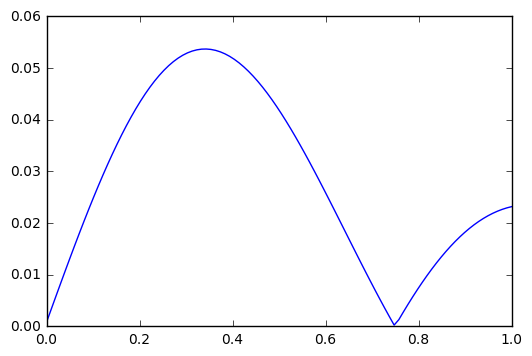

In [3]:
%matplotlib inline   
import differences as diff
import matplotlib.pyplot as plt
import numpy as np

def myfun(x=0):
    import numpy as np
    return np.exp(-x**2)*np.sin(np.pi*x)

def myder(x=0):
    from math import sin,exp,pi
    temp=np.exp(-x**2)
    return temp*(pi*np.cos(np.pi*x)-2*x*np.sin(np.pi*x))
    
X=np.linspace(0,1,100)
dX=diff.for_diff(myfun,X,.01)
abs_err=np.abs(dX-myder(X))

plt.plot(X,abs_err)
plt.show

## Where does the module file need to go?

Say you are trying to **import spam**.

When imported, the interpreter searches for spam in(in order):
1. A built-in module with that name. 
2. *spam.py* in a list of directories given by the variable *sys.path*. 
    1. The directory containing the input script (or the current directory when no file is specified).
    2. PYTHONPATH (a list of directory names, syntax as shell variable PATH).
    3. The installation-dependent default.

## Generalizations of Modules: Packages

Packages are modules with a directory structure.
You can even make packages with subpackages and simply exploit the dot.dot reference to navigate through the package to get to the function you want (e.g. matplotlib.pyplot.plot).  
If you want to develop a well-comparmentalized package you can look at online help: https://python-packaging.readthedocs.io/en/latest/


 

## Classes

Classes are a basic feature of object-oriented programming.  They are a little more complex than the *struct* features in Matlab.

In [4]:
class myClass:
    #Class attributes are variables that are shared by all objects of this class
    teacher='Varis Carey'
    off_hours='MW 1-2 TR 12:30-1:30'
    #instance variables are variables particular to an instance of the class and are
    #set in the CONSTRUCTOR
    def __init__(self,name,room):
        self.name=name
        self.room=room
        self.students=[] #empty student list
    
    #We can have other function within myclass-here is a METHOD to add_students
    def add_student(self,name):
        self.students.append(name)

c=myClass('M5660','AB4017')
d=myClass('M4650','AB4125')
print c.name
c.add_student('Michael')
c.add_student('Megan')
print c.students
print d.students

    

M5660
['Michael', 'Megan']
[]


Let's look at an example where we encounter another example of classical object oriented programming, **Inheritance**.

We start off by defining a class that solves the heat equation( a parabolic equation) that we solved numerically in Lecture II.


In [5]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d
class Parabolic_Solver:
    
    #class constructor
    def __init__(self,rhs,thermal,initial,bflux,timestep=.1,delta_x=.1,delta_y=.1,time_0=0.0,time_adaptive=False,):
        self.rhs=rhs
        self.initial=initial
        self.bflux=bflux
        self.time_adaptive=time_adaptive
        self.timestep=timestep
        self.delta_x=delta_x
        self.delta_y=delta_y
        gridx=np.linspace(0,1,np.int(1.0/delta_x+1))
        gridy=np.linspace(0,1,np.int(1.0/delta_y+1))
        self.gridx,self.gridy=np.meshgrid(gridx,gridy)
        self.time=time_0
        self.init_cond()
        self.history=self.Told
        

    #definite initial temperature field.    
    def init_cond(self):
        self.Told=self.initial(self.gridx,self.gridy)

In Lecture II we used (forward) Euler to evolve a solution to the heat equation.  What happens if you make the timestep too large?  One *cure* for this timestep restriction is to use an implicit method.

The simplest such method is (backward) Euler.  This involves solving the RHS of the Method of Lines discretization using new time information:
$$
T_{t_{i+1}}=\delta t D(T_{t_{i+1}}+\delta t T_{t_{i}}+f(t_i)
$$
which we may rewrite as a linear algebraic system for the new temperature,
$$
(I+\delta t D)T_{t_{i+1}} = \delta t T_{t_{i}} + f(t_i)
$$
The diffusion matrix $D$ is also known as the stiffness matrix.  The most straightforward way to solve this system
**implicitly** is to assemble the stiffness matrix.  As the coefficients in the PDE are not time-dependant, we only have to do this once.

We are going to define a **derived class** that implement the implicit solver.  As an optional exercise, you can also add a derived class to implement the explicit Euler method we used in Lecture II.

In [6]:
class Implicit_Time_Solver(Parabolic_Solver):  #this is a derived class from Parabolic Solver

    def __init__(self,rhs,thermal,initial,bflux,timestep=.1,delta_x=.1,delta_y=.1,time_0=0.0,time_adaptive=False): 
        # Call base class initializer
        Parabolic_Solver.__init__(self,rhs,thermal,initial,bflux,timestep,delta_x,delta_y,time_0,time_adaptive)
        # assemble the stiffness matrix
        self.assemble(thermal)
    
    def assemble(self,thermal):
        DOF_ind=np.zeros(np.shape(self.gridx),dtype=int)
        MX=np.int(1.0/self.delta_x)+1
        MY=np.int(1.0/self.delta_y)+1
        temp=0
        for j in range(MY):    
            for i in range(MX):
              DOF_ind[i,j]=temp
              temp+=1
        
        self.stiffness=np.zeros((temp,temp))
        #internal degrees of freedom
        for i in range(1,MX-1):
            for j in range(1,MY-1):
                center=DOF_ind[i,j]
                left=DOF_ind[i-1,j]
                right=DOF_ind[i+1,j]
                up=DOF_ind[i,j+1]
                down=DOF_ind[i,j-1]
                self.stiffness[center,center]=2.0*(thermal[0]/self.delta_x**2+thermal[1]/self.delta_y**2)
                self.stiffness[center,left]=-thermal[0]/self.delta_x**2
                self.stiffness[center,right]=self.stiffness[center,left]
                self.stiffness[center,down]=-thermal[1]/self.delta_y**2
                self.stiffness[center,up]=self.stiffness[center,down]
        #vertical boundaries (x=0, x=1)
        for i  in range(MX):
            self.stiffness[DOF_ind[i,0],DOF_ind[i,0]]=(1.0/self.delta_y-1)/self.timestep
            self.stiffness[DOF_ind[i,0],DOF_ind[i,1]]=-1.0/self.delta_y/self.timestep 
            self.stiffness[DOF_ind[i,MY-1],DOF_ind[i,MY-1]]=(1.0/self.delta_y -1)/self.timestep 
            self.stiffness[DOF_ind[i,MY-1],DOF_ind[i,MY-2]]=-1.0/self.delta_y/self.timestep
        #horizontal boundaries (y=0,y=1)
        for j in range(MY):
            self.stiffness[DOF_ind[0,j],DOF_ind[0,j]]=(1.0/self.delta_x -1)/self.timestep
            self.stiffness[DOF_ind[0,j],DOF_ind[1,j]]=-1.0/self.delta_x/self.timestep
            self.stiffness[DOF_ind[MX-1,j],DOF_ind[MX-1,j]]=(1.0/self.delta_x -1)/self.timestep 
            self.stiffness[DOF_ind[MX-1,j],DOF_ind[MX-2,j]]=-1.0/self.delta_x/self.timestep
        self.DOF_ind=DOF_ind
        
    def advance(self):
        MX=np.int(1.0/self.delta_x)+1
        MY=np.int(1.0/self.delta_y)+1
        Mat=np.eye(MX*MY)+self.timestep*self.stiffness
        data=self.timestep*self.Told  #will overwrite boundary terms.
        #compute right hand side
        #internal degrees of freedom
        #evaluate rhs, including boundary
        temp=self.rhs(self.gridx,self.gridy,self.time)
        print np.size(temp)
        temp=np.reshape(temp,np.size(data))
        #interal DOF
        data[self.DOF_ind[1:MX-2,1:MY-2]]+=temp[self.DOF_ind[1:MX-2,1:MY-2]]
        #boundary conditions
        for i in range(MX-1):
             data[self.DOF_ind[i,0]]=self.bflux(self.gridx[i,0],0,self.time)
             data[self.DOF_ind[i,MY-1]]=self.bflux(self.gridx[i,MY-1],1,self.time)
        for j in range(MY-1):
             data[self.DOF_ind[0,j]]=self.bflux(0,self.gridx[0,j],self.time)
             data[self.DOF_ind[MX-1,j]]=self.bflux(1,self.gridx[MX-1,j],self.time)
        self.Tnew=np.linalg.solve(Mat,data)
        self.time+=self.timestep
        self.Told=self.Tnew
        self.history=np.vstack((self.history,self.Told))
    
        
      
# We also need to redefine the initial condition function to work with our solution vector.
    def init_cond(self):
             Parabolic_Solver.init_cond(self)
             print np.size(self.Told)
             self.Told=np.reshape(self.Told,np.size(self.Told))  #make the solution vector one dimensional for the linear algebra.
             print np.shape(self.Told)
             
# plotter for a specific timestep.
    def plot_state(self,which_step):
        # construct meshgrid vector from history vector for plotting
        MX,MY=np.shape(self.gridx)
        plotwhat=np.zeros((MX,MY))
        for i in range(MX):
            for j in range(MY):
                plotwhat[i,j]=self.history[which_step,self.DOF_ind[i,j]]
        #print plotwhat
        fig = plt.figure()
        ax1 = fig.add_subplot(1, 1, 1, projection='3d')

        ax1.plot_wireframe(self.gridx, self.gridy, plotwhat) 
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_zlabel('T')
        titstring='Approx. Solution at Timestep '+str(which_step)
        ax1.set_title(titstring)        


This code block corresponds to running our actual problem from Lecture II but using the backward Euler time integrator.

121
(121,)
121
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    9.54915028e-01   1.81635632e+00   2.50000000e+00   2.93892626e+00
    3.09016994e+00   2.93892626e+00   2.50000000e+00   1.81635632e+00
    9.54915028e-01   3.78436673e-16   0.00000000e+00   1.81635632e+00
    3.45491503e+00   4.75528258e+00   5.59016994e+00   5.87785252e+00
    5.59016994e+00   4.75528258e+00   3.45491503e+00   1.81635632e+00
    7.19829328e-16   0.00000000e+00   2.50000000e+00   4.75528258e+00
    6.54508497e+00   7.69420884e+00   8.09016994e+00   7.69420884e+00
    6.54508497e+00   4.75528258e+00   2.50000000e+00   9.90760073e-16
    0.00000000e+00   2.93892626e+00   5.59016994e+00   7.69420884e+00
    9.04508497e+00   9.51056516e+00   9.04508497e+00   7.69420884e+00
    5.59016994e+00   2.93892626e+00   1.16470832e-15   0.00000000e+00
    3

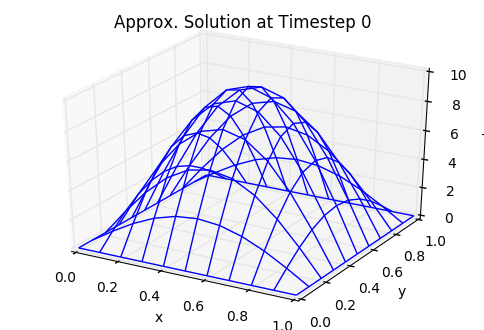

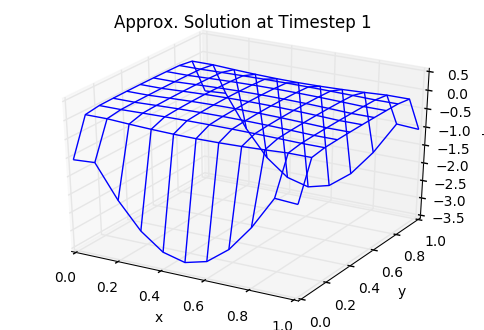

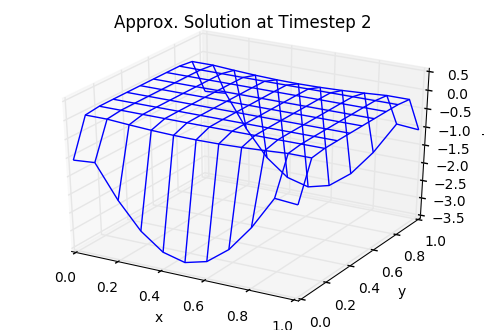

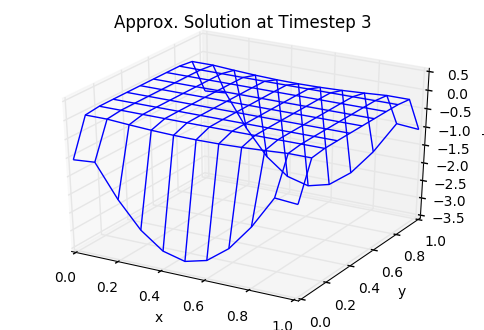

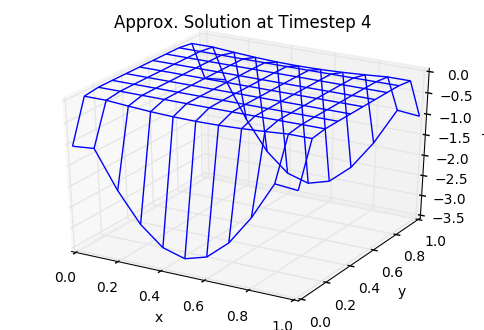

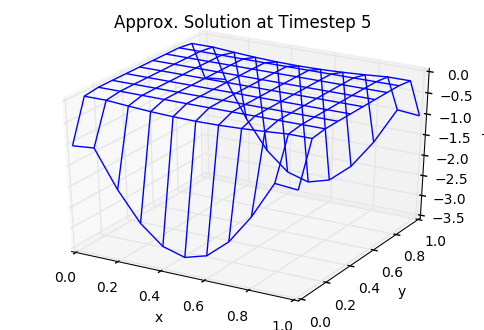

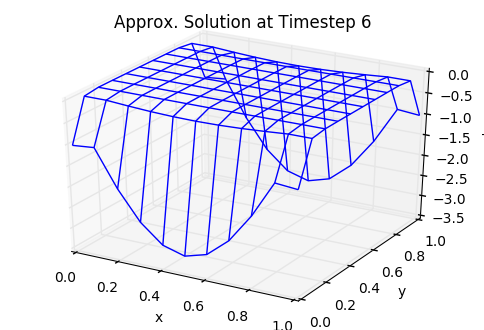

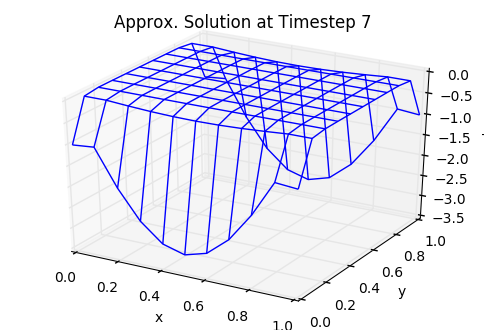

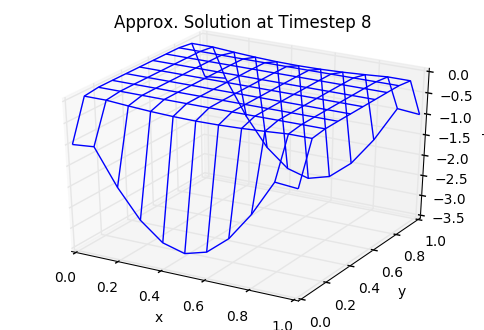

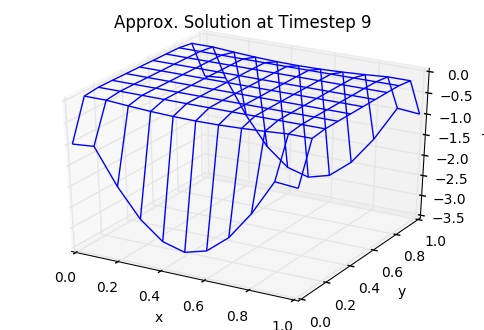

In [7]:
def rhs(x_i, y_j, t_n):
    return np.zeros(np.shape(x_i))

def initial(x,y):
    ic = 10*np.sin(np.pi*x)*np.sin(np.pi*y)
    return ic

def bflux(x_i, y_j, t_n):
    if x_i == 0.0 or x_i == 1.0:
        z = -10*np.pi*np.exp(-t_n)*np.sin(np.pi*y_j)
    else:
        z = -10*np.pi*np.exp(-t_n)*np.sin(np.pi*x_i)
    return z

thermal=np.array([1/(2*np.pi**2),1/(2*np.pi**2)])
test=Implicit_Time_Solver(rhs,thermal,initial,bflux,.01,.1,.1,0,False)
for i in range(10):
    test.advance()
    print test.history
    test.plot_state(i)

In [ ]:
#Exercise
class Explicit_Time_Solver(Parabolic_Solver):
        
    def __init__(self,method='FE'):
        
    def advance(
    